# Experiment 1 - Speed test

In [2]:
from dataset_loader import load_dataset
from utils import *
import timeit

import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import os

In [3]:
# Specify the directory you want to read from
directory = os.path.join(os.path.dirname(os.getcwd()), 'ViT-L14')

# size = 252001
files_set_4 = [
    '003.txt', '004.txt', '005.txt', 
    '006.txt', '007.txt', '048.txt',
    '049.txt', '055.txt', '056.txt',
    '057.txt'
]

In [4]:
image_names, dataset = load_dataset(directory, files_set_4)

Processing file: 003.txt
	Number of vectors: 5516
Processing file: 004.txt
	Number of vectors: 8386
Processing file: 005.txt
	Number of vectors: 13638
Processing file: 006.txt
	Number of vectors: 17044
Processing file: 007.txt
	Number of vectors: 15181
Processing file: 048.txt
	Number of vectors: 26687
Processing file: 049.txt
	Number of vectors: 44032
Processing file: 055.txt
	Number of vectors: 43070
Processing file: 056.txt
	Number of vectors: 39764
Processing file: 057.txt
	Number of vectors: 38683

Number of vectors in all files: 252001
Number of dimensions: 768


In [5]:
# Define dataset sizes to test
dataset_sizes = [
                25_000, 
                50_000, 
                75_000, 
                100_000,
                125_000,
                150_000,
                175_000,
                200_000,
                225_000,
                250_000
]

outer_repetitions = 4
num_executions = 4

## Pairwise Computation

In [6]:
pairwise_results = pd.DataFrame(columns=['Dataset Size', 'Mahalanobis Time', 'Euclidean Time', 'Cosine Distance Time'])

In [7]:
M = np.eye(len(dataset[0]))

for size in dataset_sizes:
    euclidean_total_time = 0
    mahalanobis_total_time = 0
    cosine_total_time = 0
    
    # Select a subset of the full dataset of the given size
    sub_dataset = dataset[:size]
    sub_dataset = np.array(sub_dataset)
    
    for _ in range(outer_repetitions):
        euclidean_time = 0
        mahalanobis_time = 0
        cosine_time = 0
        
        for _ in range(num_executions):
            target_vector = random.choice(sub_dataset)
        
            # Time Cosine distance
            start_time = timeit.default_timer()
            distances = [cosine_distance_norm(target_vector, vector) for vector in sub_dataset]
            cosine_time += timeit.default_timer() - start_time
            
            # Time Euclidean distance
            start_time = timeit.default_timer()
            distances = [euclidean_distance(target_vector, vector) for vector in sub_dataset]
            euclidean_time += timeit.default_timer() - start_time
            
            # Time Mahalanobis distance
            start_time = timeit.default_timer()
            distances = [mahalanobis_distance(target_vector, vector, M) for vector in sub_dataset]
            mahalanobis_time += timeit.default_timer() - start_time
        
        # Accumulate the total times over all outer repetitions
        euclidean_total_time += euclidean_time
        mahalanobis_total_time += mahalanobis_time
        cosine_total_time += cosine_time
    
    # Calculate the average times over all repetitions
    average_euclidean_time = euclidean_total_time / (outer_repetitions * num_executions)
    average_mahalanobis_time = mahalanobis_total_time / (outer_repetitions * num_executions)
    average_cosine_time = cosine_total_time / (outer_repetitions * num_executions) 
    
    # Append results to the DataFrame
    pairwise_results = pairwise_results.append(
        {
            'Dataset Size': size, 
            'Mahalanobis Time': average_mahalanobis_time, 
            'Euclidean Time': average_euclidean_time,
            'Cosine Distance Time': average_cosine_time
        },
        ignore_index=True
    )

Dataset size 25000
Dataset size 50000
Dataset size 75000
Dataset size 100000
Dataset size 125000
Dataset size 150000
Dataset size 175000
Dataset size 200000
Dataset size 225000
Dataset size 250000


In [8]:
pairwise_results.to_pickle('experiment_1_pairwise_results.pkl')

In [9]:
pairwise_results = pd.read_pickle('experiment_1_pairwise_results.pkl')

In [11]:
pairwise_results

,Dataset Size,Mahalanobis Time,Euclidean Time,Cosine Distance Time
0,25000.0,9.551355,0.248750,0.055019
1,50000.0,20.135353,0.449551,0.098065
2,75000.0,28.575974,0.632663,0.152277
3,100000.0,37.534196,0.876010,0.189418
4,125000.0,45.749019,1.068575,0.241426
5,150000.0,56.415583,1.287203,0.299880
6,175000.0,67.208433,1.479820,0.346836
7,200000.0,77.544049,1.693947,0.390540
8,225000.0,87.143139,1.919247,0.458484
9,250000.0,99.099087,2.126548,0.529212


In [12]:
# Calculate the speedup of Euclidean over Mahalanobis
pairwise_results['Mahal/Euc Speedup'] = pairwise_results['Mahalanobis Time'] / pairwise_results['Euclidean Time']

# Calculate the speedup of Cosine over Euclidean
pairwise_results['Euc/Cos Speedup'] = pairwise_results['Euclidean Time'] / pairwise_results['Cosine Distance Time']

pairwise_results

,Dataset Size,Mahalanobis Time,Euclidean Time,Cosine Distance Time,Mahal/Euc Speedup,Euc/Cos Speedup
0,25000.0,9.551355,0.248750,0.055019,38.397422,4.521146
1,50000.0,20.135353,0.449551,0.098065,44.789946,4.584203
2,75000.0,28.575974,0.632663,0.152277,45.167766,4.154694
3,100000.0,37.534196,0.876010,0.189418,42.846755,4.624757
4,125000.0,45.749019,1.068575,0.241426,42.813106,4.426092
5,150000.0,56.415583,1.287203,0.299880,43.828035,4.292398
6,175000.0,67.208433,1.479820,0.346836,45.416617,4.266629
7,200000.0,77.544049,1.693947,0.390540,45.777132,4.337445
8,225000.0,87.143139,1.919247,0.458484,45.404857,4.186076
9,250000.0,99.099087,2.126548,0.529212,46.600916,4.018327


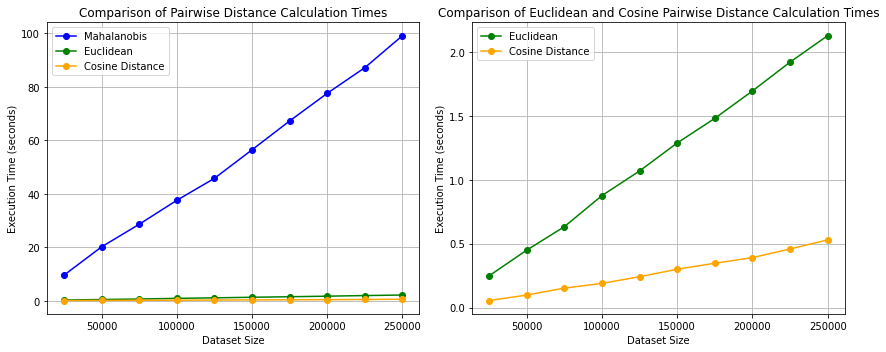

In [13]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# First subplot for Mahalanobis, Euclidean, and Cosine Distance times
ax1.plot(pairwise_results['Dataset Size'], pairwise_results['Mahalanobis Time'], marker='o', label='Mahalanobis', linestyle='-', color='blue')
ax1.plot(pairwise_results['Dataset Size'], pairwise_results['Euclidean Time'], marker='o', label='Euclidean', linestyle='-', color='green')
ax1.plot(pairwise_results['Dataset Size'], pairwise_results['Cosine Distance Time'], marker='o', label='Cosine Distance', linestyle='-', color='orange')
ax1.set_xlabel('Dataset Size')
ax1.set_ylabel('Execution Time (seconds)')
ax1.set_title('Comparison of Pairwise Distance Calculation Times')
ax1.legend()
ax1.grid(True)

# Second subplot for Euclidean and Cosine Distance times
ax2.plot(pairwise_results['Dataset Size'], pairwise_results['Euclidean Time'], marker='o', label='Euclidean', linestyle='-', color='green')
ax2.plot(pairwise_results['Dataset Size'], pairwise_results['Cosine Distance Time'], marker='o', label='Cosine Distance', linestyle='-', color='orange')
ax2.set_xlabel('Dataset Size')
ax2.set_ylabel('Execution Time (seconds)')
ax2.set_title('Comparison of Euclidean and Cosine Pairwise Distance Calculation Times')
ax2.legend()
ax2.grid(True)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

--------

## Vectorized Computation

In [14]:
# Prepare results DataFrame
results = pd.DataFrame(columns=['Dataset Size', 'Mahalanobis Time', 'Euclidean Time', 'Cosine Distance Time'])

In [ ]:
M = np.eye(len(dataset[0]))

for size in dataset_sizes:
    euclidean_total_time = 0
    mahalanobis_total_time = 0
    cosine_total_time = 0
    
    # Randomly select a subset of the full dataset of the given size
    sub_dataset = dataset[:size]
    sub_dataset = np.array(sub_dataset)
    
    for _ in range(outer_repetitions):
        # Interleave Euclidean and Mahalanobis executions
        euclidean_time = 0
        mahalanobis_time = 0
        cosine_time = 0

        for _ in range(num_executions):
            target_vector = random.choice(sub_dataset)  # 768-dimensional target vector
            target_vector = np.array(target_vector)
            
            # Time cosine distance
            start_time = timeit.default_timer()
            vectorized_cosine_distances_normalized(target_vector, sub_dataset)
            cosine_time += timeit.default_timer() - start_time
            
            # Time Euclidean distance
            start_time = timeit.default_timer()
            vectorized_euclidean_distances(target_vector, sub_dataset)
            euclidean_time += timeit.default_timer() - start_time
            
            # Time Mahalanobis distance
            start_time = timeit.default_timer()
            vectorized_mahalanobis_distances(target_vector, sub_dataset, M)
            mahalanobis_time += timeit.default_timer() - start_time

        # Accumulate the total times over all outer repetitions
        euclidean_total_time += euclidean_time
        mahalanobis_total_time += mahalanobis_time
        cosine_total_time += cosine_time
        
    print("----")
    # Calculate the average times over all repetitions
    average_euclidean_time = euclidean_total_time / (outer_repetitions * num_executions)
    average_mahalanobis_time = mahalanobis_total_time / (outer_repetitions * num_executions)
    average_cosine_time = cosine_total_time / (outer_repetitions * num_executions)

    # Append results to the DataFrame
    results = results.append(
        {
            'Dataset Size': size,
            'Mahalanobis Time': average_mahalanobis_time, 
            'Euclidean Time': average_euclidean_time,
            'Cosine Distance Time': average_cosine_time
        }, 
        ignore_index=True
    )

In [16]:
results.to_pickle('experiment_1_vectorized_results.pkl')

In [17]:
results = pd.read_pickle('experiment_1_vectorized_results.pkl')

In [18]:
results

,Dataset Size,Mahalanobis Time,Euclidean Time,Cosine Distance Time
0,25000.0,0.522130,0.112920,0.006906
1,50000.0,0.890111,0.240141,0.013037
2,75000.0,1.221432,0.366506,0.018953
3,100000.0,1.647363,0.494123,0.027765
4,125000.0,2.052223,0.612078,0.035710
5,150000.0,2.426511,0.761364,0.037746
6,175000.0,2.852997,0.900459,0.044162
7,200000.0,3.329656,1.044550,0.051969
8,225000.0,3.862071,1.203818,0.056886
9,250000.0,4.386001,1.355648,0.064748


In [19]:
# Calculate the speedup of Euclidean over Mahalanobis
results['Mahal/Euc Speedup'] = results['Mahalanobis Time'] / results['Euclidean Time']

# Calculate the speedup of Cosine over Euclidean
results['Euc/Cos Speedup'] = results['Euclidean Time'] / results['Cosine Distance Time']

# Display the updated DataFrame
results

,Dataset Size,Mahalanobis Time,Euclidean Time,Cosine Distance Time,Mahal/Euc Speedup,Euc/Cos Speedup
0,25000.0,0.522130,0.112920,0.006906,4.623882,16.350218
1,50000.0,0.890111,0.240141,0.013037,3.706612,18.419773
2,75000.0,1.221432,0.366506,0.018953,3.332638,19.337137
3,100000.0,1.647363,0.494123,0.027765,3.333912,17.796442
4,125000.0,2.052223,0.612078,0.035710,3.352879,17.140033
5,150000.0,2.426511,0.761364,0.037746,3.187058,20.170730
6,175000.0,2.852997,0.900459,0.044162,3.168380,20.389740
7,200000.0,3.329656,1.044550,0.051969,3.187645,20.099380
8,225000.0,3.862071,1.203818,0.056886,3.208185,21.161953
9,250000.0,4.386001,1.355648,0.064748,3.235354,20.937306


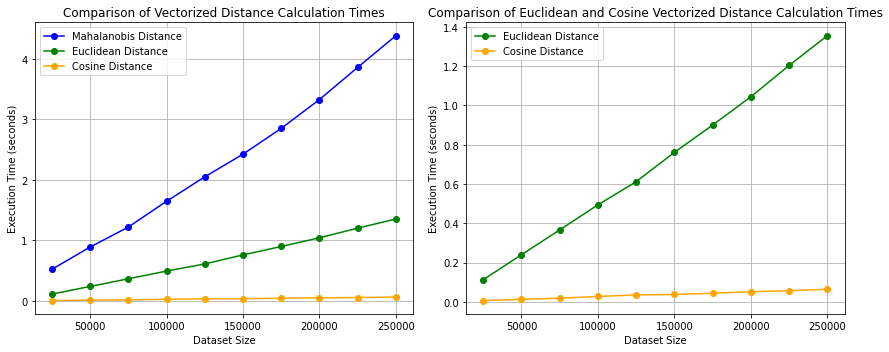

In [20]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# First subplot for Mahalanobis, Euclidean, and Cosine Distance times
ax1.plot(results['Dataset Size'], results['Mahalanobis Time'], marker='o', label='Mahalanobis Distance', linestyle='-', color='blue')
ax1.plot(results['Dataset Size'], results['Euclidean Time'], marker='o', label='Euclidean Distance', linestyle='-', color='green')
ax1.plot(results['Dataset Size'], results['Cosine Distance Time'], marker='o', label='Cosine Distance', linestyle='-', color='orange')
ax1.set_xlabel('Dataset Size')
ax1.set_ylabel('Execution Time (seconds)')
ax1.set_title('Comparison of Vectorized Distance Calculation Times')
ax1.legend()
ax1.grid(True)

# Second subplot for Euclidean and Cosine Distance times
ax2.plot(results['Dataset Size'], results['Euclidean Time'], marker='o', label='Euclidean Distance', linestyle='-', color='green')
ax2.plot(results['Dataset Size'], results['Cosine Distance Time'], marker='o', label='Cosine Distance', linestyle='-', color='orange')
ax2.set_xlabel('Dataset Size')
ax2.set_ylabel('Execution Time (seconds)')
ax2.set_title('Comparison of Euclidean and Cosine Vectorized Distance Calculation Times')
ax2.legend()
ax2.grid(True)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

In [21]:
df_formatted = results.copy() 

# Format 'Mean Count' in the new DataFrame
df_formatted['Dataset Size'] = df_formatted['Dataset Size'].astype(int).apply(lambda x: f"{x:,}")


df_formatted.iloc[:, :-2].style.hide_index()

Dataset Size,Mahalanobis Time,Euclidean Time,Cosine Distance Time
"25,000",0.522130,0.112920,0.006906
"50,000",0.890111,0.240141,0.013037
"75,000",1.221432,0.366506,0.018953
"100,000",1.647363,0.494123,0.027765
"125,000",2.052223,0.612078,0.035710
"150,000",2.426511,0.761364,0.037746
"175,000",2.852997,0.900459,0.044162
"200,000",3.329656,1.044550,0.051969
"225,000",3.862071,1.203818,0.056886
"250,000",4.386001,1.355648,0.064748


In [22]:
df_formatted[['Dataset Size', 'Mahal/Euc Speedup', 'Euc/Cos Speedup']].style.hide_index()

Dataset Size,Mahal/Euc Speedup,Euc/Cos Speedup
"25,000",4.623882,16.350218
"50,000",3.706612,18.419773
"75,000",3.332638,19.337137
"100,000",3.333912,17.796442
"125,000",3.352879,17.140033
"150,000",3.187058,20.170730
"175,000",3.168380,20.389740
"200,000",3.187645,20.099380
"225,000",3.208185,21.161953
"250,000",3.235354,20.937306


In [23]:
# Merge the two DataFrames on 'Dataset Size' to align the pairwise and vectorized results
comparison_df = pd.merge(pairwise_results, results, on="Dataset Size", suffixes=('_pairwise', '_vectorized'))

comparison_df['Mahal Speedup (Pairwise/Vectorized)'] = comparison_df['Mahalanobis Time_pairwise'] / comparison_df['Mahalanobis Time_vectorized']
comparison_df['Euc Speedup (Pairwise/Vectorized)'] = comparison_df['Euclidean Time_pairwise'] / comparison_df['Euclidean Time_vectorized']
comparison_df['Cosine Speedup (Pairwise/Vectorized)'] = comparison_df['Cosine Distance Time_pairwise'] / comparison_df['Cosine Distance Time_vectorized']

# Final table with consistent naming
comparison_table = comparison_df[['Dataset Size', 
                                  'Mahal Speedup (Pairwise/Vectorized)', 
                                  'Euc Speedup (Pairwise/Vectorized)', 
                                  'Cosine Speedup (Pairwise/Vectorized)']]

# Display the comparison table
comparison_table

,Dataset Size,Mahal Speedup (Pairwise/Vectorized),Euc Speedup (Pairwise/Vectorized),Cosine Speedup (Pairwise/Vectorized)
0,25000.0,18.293049,2.202880,7.966469
1,50000.0,22.621178,1.872025,7.521980
2,75000.0,23.395473,1.726201,8.034236
3,100000.0,22.784416,1.772858,6.822103
4,125000.0,22.292423,1.745816,6.760668
5,150000.0,23.249675,1.690655,7.944682
6,175000.0,23.557134,1.643406,7.853652
7,200000.0,23.288909,1.621700,7.514831
8,225000.0,22.563837,1.594300,8.059695
9,250000.0,22.594406,1.568658,8.173420
